In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# from captum.attr import IntegratedGradients
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import copy
from transformers import Trainer, TrainingArguments

In [3]:
model_name = "vedantM/NucArg_LongRead"
model = AutoModelForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/383M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/928 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

## Prepare test data

In [4]:
ds_arg = pd.read_csv('/content/drive/MyDrive/PUBH 8885 CB/long_read_arg_dataset.csv')
ds_arg.head()

,id,db,type,sequence,dna_seq
0,B9J113,UNIPROT,beta_lactam,MKHKNQATHKEFSQLEKKFDARLGLYAIDTGTNQTIAYRPNERFAF...,GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...
1,A0A147H3Q5,UNIPROT,bacitracin,MDLWSALQALILGIVEGITEFLPISSTGHQIIVADLIGFGGERAIA...,ATGAATTGGTGGGAGCTGTTTGTTGCTTTAATTCTTGGTCTAGTGG...
2,A0A133N6E2,UNIPROT,bacitracin,MGIDFLFILKALIIAVVEGLTEFVPVSSTGHMILVGDLIHFNTQSG...,ATGGGAATTGATTTTTTATTCATACTTAAGGCCTTAATAATCGCAG...
3,A0A024P8A8,UNIPROT,beta_lactam,MKKIYESKFSMRQVKMFMSLLVLITLAACFDSTNSTNVSSKEGNEV...,TCACTTTAGGGCATTAAGAGCGACCTTGGCAGCCTGCGCAATTAGC...
4,A0A0Q3WM94,UNIPROT,chloramphenicol,MFKQIDENYPRKEHFHHYMTVTRCTYSLVIDLDITKLYAILKEKRL...,ATGAATGCAATTATGTTAGTTATCATTCTTGCACTAGTTGAAGGTA...


In [5]:
type_counts = ds_arg['type'].value_counts()
ds_arg = ds_arg[ds_arg['type'].isin(type_counts[type_counts > 1].index)]

In [6]:
# Create label encoder for drug resistance types
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(ds_arg['type'])

In [7]:
# Split data
sequences = ds_arg['dna_seq'].values


dataset = pd.DataFrame({
    'sequence': sequences,
    'label': labels
})
print(dataset)

                                                sequence  label
0      GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...      2
1      ATGAATTGGTGGGAGCTGTTTGTTGCTTTAATTCTTGGTCTAGTGG...      1
2      ATGGGAATTGATTTTTTATTCATACTTAAGGCCTTAATAATCGCAG...      1
3      TCACTTTAGGGCATTAAGAGCGACCTTGGCAGCCTGCGCAATTAGC...      2
4      ATGAATGCAATTATGTTAGTTATCATTCTTGCACTAGTTGAAGGTA...      3
...                                                  ...    ...
13354  TAACGAATTTATGATGGAATTCCATCATCGACATAGTGCTTGTCAA...     12
13355  TAACGAATTTATGATGGAATTCCATCATCGACATAGTGCTTGTCAA...     12
13356  ATCGAATTGATGATGGAATTCCATCATCAATAAATTGCTTGTCAAA...     12
13357  ATCGAATTGATGATGGAATTCCATCATCAATAAATTGCTTGTCAAA...     12
13358  ATCGAATTGATGATGGAATTCCATCATCAATAAATTGCTTGTCAAA...     12

[13359 rows x 2 columns]


In [8]:
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(class_mapping)

{'aminoglycoside': 0, 'bacitracin': 1, 'beta_lactam': 2, 'chloramphenicol': 3, 'fosfomycin': 4, 'fosmidomycin': 5, 'fusidic_acid': 6, 'glycopeptide': 7, 'kasugamycin': 8, 'macrolide-lincosamide-streptogramin': 9, 'multidrug': 10, 'mupirocin': 11, 'non_resistant': 12, 'peptide': 13, 'polymyxin': 14, 'qa_compound': 15, 'quinolone': 16, 'rifampin': 17, 'sulfonamide': 18, 'tetracenomycin': 19, 'tetracycline': 20, 'trimethoprim': 21, 'tunicamycin': 22}


In [ ]:
torch.cuda.empty_cache()

In [9]:
train_sequences, test_sequences, train_labels, test_labels = train_test_split(dataset['sequence'], dataset['label'], test_size=0.08, random_state=42)

In [10]:
# Sequence splitting function
def split_sequence(sequence, max_len=1024, overlap=512):
    chunks = []
    for i in range(0, len(sequence), max_len - overlap):
        chunk = sequence[i:i + max_len]
        if len(chunk) > 0:
            chunks.append(chunk)
    return chunks
# Preprocess data (split and label encoding)
def preprocess_data(sequences, labels, max_len=1024, overlap=512):
    split_sequences = []
    split_labels = []
    for seq, label in zip(sequences, labels):
        chunks = split_sequence(seq, max_len=max_len, overlap=overlap)
        split_sequences.extend(chunks)
        split_labels.extend([label] * len(chunks))
    return split_sequences, split_labels

# Tokenization and Dataset class
class ArgDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer, max_len=1024):
        self.encodings = tokenizer(
            sequences,
            truncation=True,
            padding=True,
            max_length=max_len,
            return_tensors="pt",
        )
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [11]:
# Split and preprocess the sequences
test_sequences, test_labels = preprocess_data(test_sequences, test_labels)

In [12]:
# Create datasets
test_dataset = ArgDataset(test_sequences, test_labels, tokenizer)

In [13]:
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [14]:
set(test_labels)

{0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 20, 21}

## Ablation Tests

In [15]:
def ablate_neurons(tensor, percentage):
    num_neurons = tensor.size(-1)
    num_to_ablate = int(percentage * num_neurons)

    # Create a mask for keeping or dropping neurons
    mask = torch.ones(num_neurons, device=tensor.device)
    mask[:num_to_ablate] = 0
    mask = mask[torch.randperm(num_neurons)]  # Shuffle mask

    return tensor * mask

In [14]:
# # Apply ablation to the classification head's dense layer
# with torch.no_grad():
#     # Convert the output of ablate_neurons to a Parameter
#     ablated_weight = ablate_neurons(model.classifier.dense.weight, percentage=0.2)
#     model.classifier.dense.weight = torch.nn.Parameter(ablated_weight)

In [16]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
model = model.to(device)

In [19]:
# Setup Trainer
trainer = Trainer(
    model=model.to(device),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [20]:
results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
results

{'eval_loss': 0.40833431482315063,
 'eval_model_preparation_time': 0.0059,
 'eval_accuracy': 0.9018355945730248,
 'eval_precision': 0.9018952614165529,
 'eval_recall': 0.9018355945730248,
 'eval_f1': 0.9007492032358536,
 'eval_runtime': 175.0364,
 'eval_samples_per_second': 14.317,
 'eval_steps_per_second': 1.794}

In [21]:
percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracies = []

### Neuron Ablation

In [23]:
for p in percentages:
    # Apply ablation
    with torch.no_grad():
        ablated_weight = ablate_neurons(
            model.classifier.dense.weight, percentage=p
        )
        # Convert the ablated weight to a Parameter
        model.classifier.dense.weight = torch.nn.Parameter(ablated_weight)
    # Evaluate model
    result = trainer.evaluate()
    accuracies.append(result["eval_accuracy"])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [24]:
accuracies

[0.9018355945730248,
 0.9022346368715084,
 0.9022346368715084,
 0.9014365522745411,
 0.8986432561851556,
 0.8950518754988028,
 0.8563447725458898,
 0.7913008778930567,
 0.518754988028731,
 0.3583399840383081]

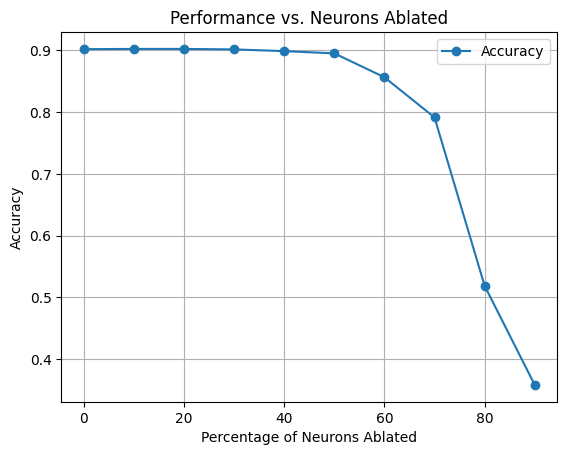

In [25]:
# Plot performance vs. neurons removed
plt.plot([p * 100 for p in percentages], accuracies, marker="o", label="Accuracy")
plt.title("Performance vs. Neurons Ablated")
plt.xlabel("Percentage of Neurons Ablated")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Layer-Wise Sensitivity Heatmap

In [50]:
# Define layers to test and percentages to ablate
layers = ["classifier.dense",
          "esm.encoder.layer[0].intermediate.dense",
          "esm.encoder.layer[1].intermediate.dense"]

# Store results in a matrix
layer_data = []
percentages = [0.1, 0.2, 0.5]

In [31]:
for layer_name in layers:
    layer_results = []
    for p in percentages:
        # Ablate neurons in the selected layer
        layer = eval(f"model.{layer_name}")
        with torch.no_grad():
            layer.weight = torch.nn.Parameter(ablate_neurons(layer.weight, percentage=p))

        # Evaluate performance
        result = trainer.evaluate()
        layer_results.append(result["eval_accuracy"])
    layer_data.append(layer_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

SyntaxError: invalid syntax (<string>, line 1)

In [32]:
layer_data

[[0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081,
  0.3583399840383081]]

In [33]:
# Convert to a NumPy array for visualization
layer_data = np.array(layer_data)

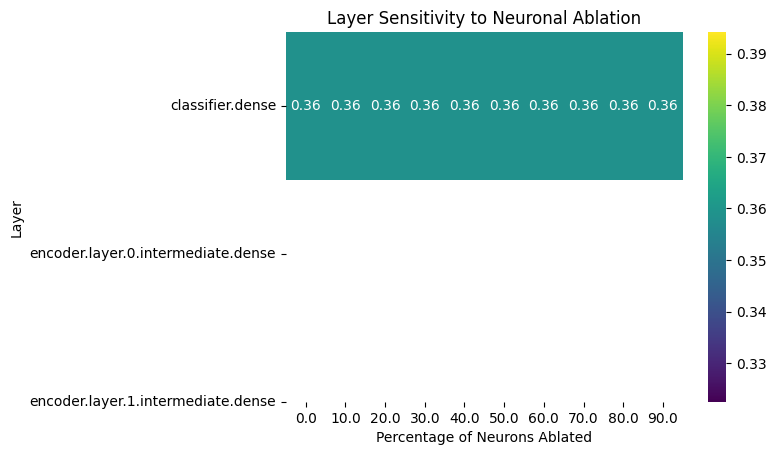

In [34]:
# Plot heatmap
sns.heatmap(layer_data, annot=True, cmap="viridis", xticklabels=[p * 100 for p in percentages], yticklabels=layers)
plt.title("Layer Sensitivity to Neuronal Ablation")
plt.xlabel("Percentage of Neurons Ablated")
plt.ylabel("Layer")
plt.show()

### Clustering

In [64]:
model_h = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           ignore_mismatched_sizes=True,
                                                           trust_remote_code=True,
                                                           output_hidden_states=True)

In [62]:
def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            # Move inputs to the same device as the model
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels_batch = batch["labels"].to(model.device) if "labels" in batch else None

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Extract the last hidden state (or desired layer)
            hidden_states = outputs.hidden_states  # Tuple of hidden states
            last_hidden_state = hidden_states[-1]  # Take the last layer

            # Pool embeddings (mean pooling across sequence length)
            pooled_embeddings = last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(pooled_embeddings)

            # Collect labels
            if labels_batch is not None:
                labels.append(labels_batch.cpu().numpy())

    # Concatenate all embeddings and labels
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels) if labels else None

    return embeddings, labels

In [61]:
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [65]:
embeddings, labels = get_embeddings(model_h, test_dataloader)

In [70]:
embeddings

array([[ 0.4333652 ,  0.4769534 , -0.6375476 , ...,  0.37277496,
        -0.6552095 ,  0.29958868],
       [ 0.96535945,  0.8306975 , -0.79558796, ...,  0.02952645,
        -0.63702124,  0.22937869],
       [ 0.01038288,  0.29065326,  0.16204399, ...,  0.23009133,
        -0.00931367,  1.0118687 ],
       ...,
       [ 0.7501196 ,  0.95851505, -0.7178182 , ...,  0.6238857 ,
        -0.673432  ,  0.55878776],
       [ 0.14598516,  0.15790042, -0.3284515 , ...,  0.03022845,
         0.07713453,  0.67309135],
       [ 0.26777104,  0.8777506 , -0.23357737, ...,  0.39114982,
        -0.48681396,  0.21170932]], dtype=float32)

In [71]:
import pickle

# Assuming you have your embeddings in a variable called 'embeddings'
with open('/content/drive/MyDrive/PUBH 8885 CB/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [73]:
class_mapping2 = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(class_mapping2)

{0: 'aminoglycoside', 1: 'bacitracin', 2: 'beta_lactam', 3: 'chloramphenicol', 4: 'fosfomycin', 5: 'fosmidomycin', 6: 'fusidic_acid', 7: 'glycopeptide', 8: 'kasugamycin', 9: 'macrolide-lincosamide-streptogramin', 10: 'multidrug', 11: 'mupirocin', 12: 'non_resistant', 13: 'peptide', 14: 'polymyxin', 15: 'qa_compound', 16: 'quinolone', 17: 'rifampin', 18: 'sulfonamide', 19: 'tetracenomycin', 20: 'tetracycline', 21: 'trimethoprim', 22: 'tunicamycin'}


In [66]:
# Dimensionality reduction with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

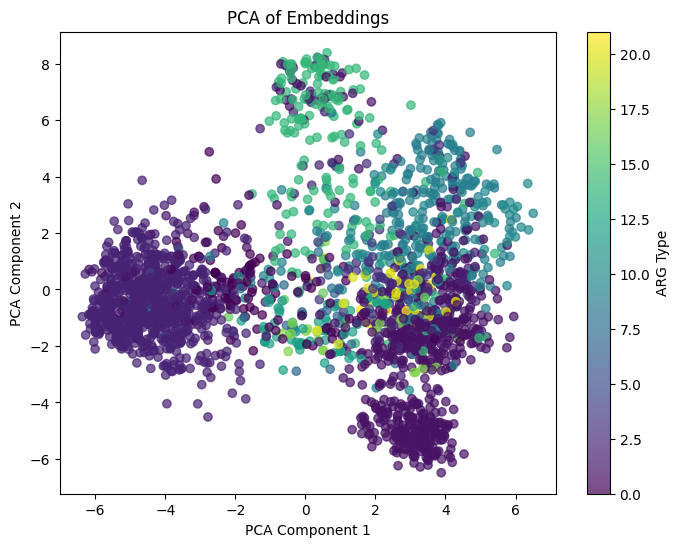

In [67]:
# Scatter plot of embeddings
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="ARG Type")
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

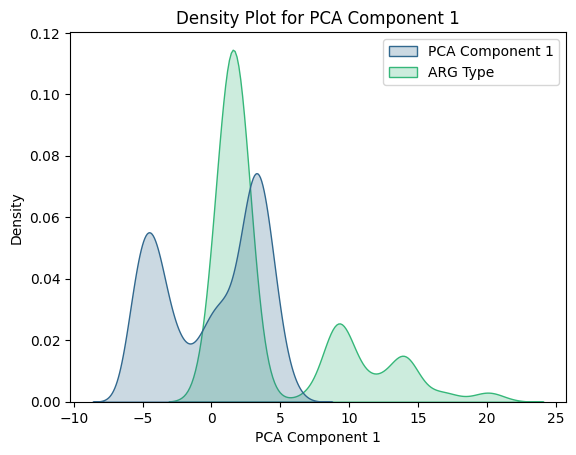

In [68]:
df = pd.DataFrame({'PCA Component 1': reduced_embeddings[:, 0], 'ARG Type': labels})

# Create a density plot for one PCA component
sns.kdeplot(data=df, fill=True, palette="viridis")
plt.title("Density Plot for PCA Component 1")
plt.xlabel("PCA Component 1")
plt.ylabel("Density")
plt.show()

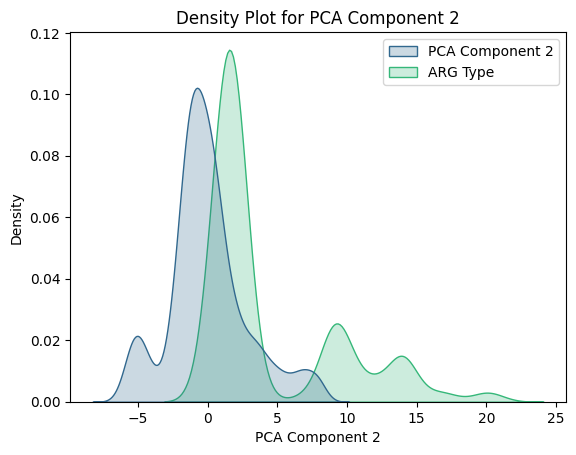

In [69]:
df = pd.DataFrame({'PCA Component 2': reduced_embeddings[:, 1], 'ARG Type': labels})

# Create a density plot for one PCA component
sns.kdeplot(data=df, fill=True, palette="viridis")
plt.title("Density Plot for PCA Component 2")
plt.xlabel("PCA Component 2")
plt.ylabel("Density")
plt.show()

In [74]:
# Generate t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)

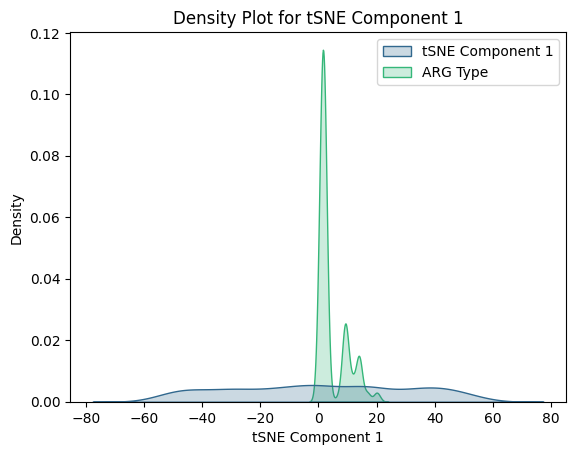

In [75]:
tdf = pd.DataFrame({'tSNE Component 1': tsne_embeddings[:, 0], 'ARG Type': labels})

# Create a density plot for one tSNE component
sns.kdeplot(data=tdf, fill=True, palette="viridis")
plt.title("Density Plot for tSNE Component 1")
plt.xlabel("tSNE Component 1")
plt.ylabel("Density")
plt.show()

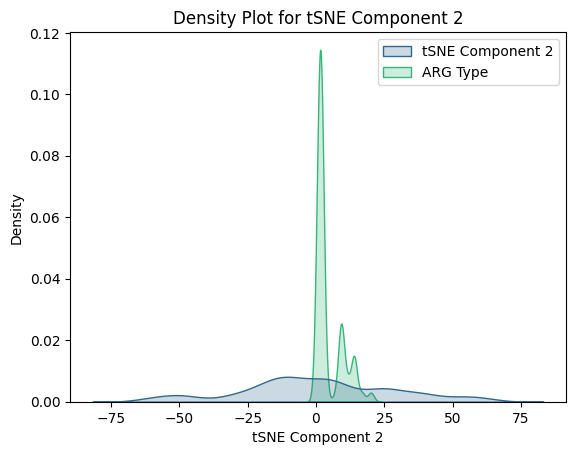

In [76]:
tdf = pd.DataFrame({'tSNE Component 2': tsne_embeddings[:, 1], 'ARG Type': labels})

# Create a density plot for one tSNE component
sns.kdeplot(data=tdf, fill=True, palette="viridis")
plt.title("Density Plot for tSNE Component 2")
plt.xlabel("tSNE Component 2")
plt.ylabel("Density")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Cluster feature importance scores
n_clusters = 10  # Adjust based on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(np.abs(logreg.coef_))

# Plot cluster importance
plt.bar(range(n_clusters), np.bincount(clusters))
plt.title("Clustered Feature Importances")
plt.xlabel("Cluster")
plt.ylabel("Number of Features")
plt.show()